In [1]:
import sys, os
sys.path.append("C:/users/kristijan/documents/projects/jhu1/")
sys.path.append("C:/users/kristijan/documents/projects/jhu1/data")
os.chdir("C:/users/kristijan/documents/projects/jhu1/")
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from stimuli import prefixes, prompts_word_prediction
import json

# Word prediction

In [2]:
input_files = [
    "word_prediction_semantic_sample.csv",
    "word_prediction_nonsemantic_sample.csv",
    "word_prediction_semantic_sample_nobeam.csv",
    "word_prediction_nonsemantic_sample_nobeam.csv"
]

dfs = []
for file in input_files:
    dfs.append(pd.read_csv(os.path.join("./output", file)))
df1 = pd.concat(dfs)

In [3]:
#df1["prompt"] = df1["prompt"].str.replace("sce1-1", "1) short")
#df1["prompt"] = df1["prompt"].str.replace("sce1-3", "2) mid")
#df1["prompt"] = df1["prompt"].str.replace("sce1-5", "3) long")

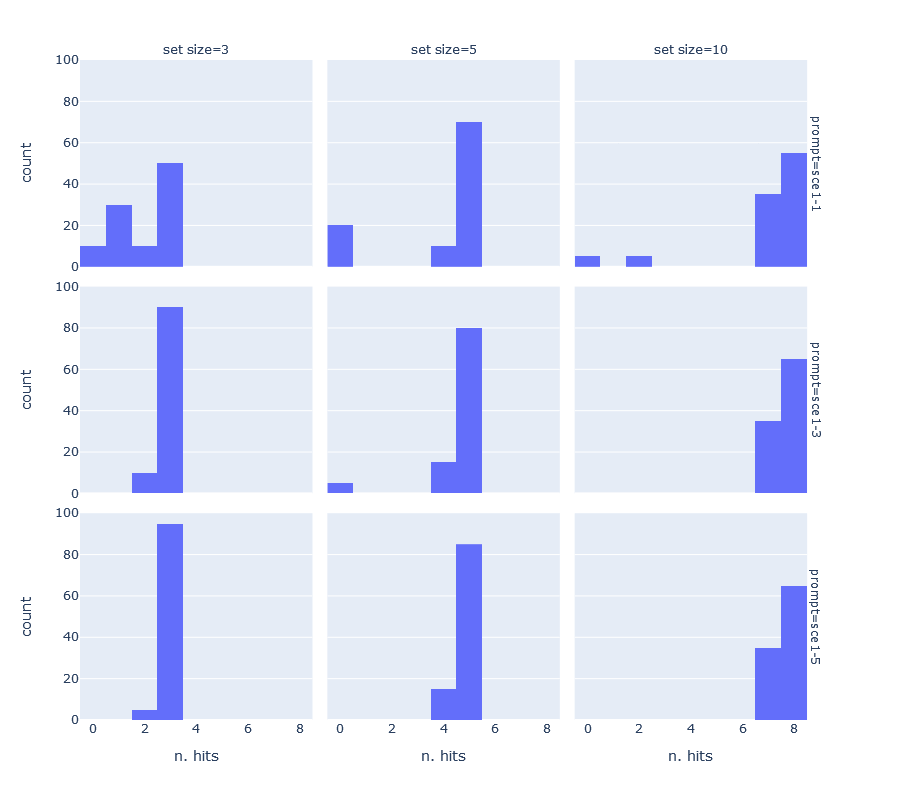

In [35]:
num_beams = 3
selection = (df1.num_beams == num_beams) & (df1.list == "nonsemantic")
data = df1.loc[selection, :].copy()
fig = px.histogram(data, x="n_correct", facet_row="prompt", facet_col="len", 
                   histnorm="percent", hover_name="string",
                   labels={"count": "percent", "n_correct": "n. hits",
                   "prompt_": "", "len": "set size"},
                   width=1500, height=800,)
fig.show()

In [34]:
fig.write_image("./figures/wordpred_hist_{}beams.png".format(num_beams))

In [45]:
n=5
dat = data.loc[data.n_correct == n, ["string", "targets", "len"]]
dat.to_csv("./misses_{}_ex.csv".format(n))

n=8
dat = data.loc[data.n_correct == n, ["string", "targets", "len"]]
dat.to_csv("./misses_{}_ex.csv".format(n))

# Word perplexity

In [26]:
files2 = [
    "perplexity_semantic_permute.csv",
    "perplexity_nonsemantic_permute.csv",
    "perplexity_semantic_repeat.csv",
    "perplexity_nonsemantic_repeat.csv"
]

dfs = []
for file in files2:
    dftmp = pd.read_csv(os.path.join("./output", file))
    dftmp["list"] = file.split("_")[1]  # add column on list composition
    dfs.append(dftmp)
df2 = pd.concat(dfs)

In [27]:
# code information on set length
df2["set_size"] = 0
three = ((df2.stimID <= 20) | ((df2.stimID > 60) & (df2.stimID <= 80)) | ((df2.stimID > 120) & (df2.stimID <= 140)))
five = ((df2.stimID > 20) & (df2.stimID <= 40)) | ((df2.stimID > 80) & (df2.stimID <= 100)) | ((df2.stimID > 140) & (df2.stimID <= 160))
ten = ((df2.stimID > 40) & (df2.stimID <= 60)) | ((df2.stimID > 100) & (df2.stimID <= 120)) | (df2.stimID > 160)
df2.loc[three, "set_size"] = 3
df2.loc[five, "set_size"] = 5
df2.loc[ten, "set_size"] = 10

In [28]:
# set uniform width and heigth
figwidth = 1200
figheight = 500

In [151]:
# let's filter some stuff
dftmp = None
semlist = "nonsemantic"
wordorder = "permute"
dftmp = df2.loc[(~df2.ispunct)  & (df2.list == semlist) & (df2.second_list == wordorder), :]          # remove punctuation
dftmp = dftmp.loc[(dftmp.trialID.isin([3])), :]  # only look at the first presentation word list
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-1", "1) short (~8 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-3", "2) mid (~30 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-5", "3) long (~60 tok)")


In [152]:
dagg = None
dagg = dftmp.groupby(["prompt", "set_size", "trialID", "stimID"]) \
            .agg({"ppl": ["mean", "std"], "token": list}) \
            .reset_index()
dagg.columns = ['_'.join(col).strip() for col in dagg.columns.values]

In [153]:
# compute relative entropy
#dftmp1 = dagg.loc[dagg.trialID_ == 1, :].reset_index().copy()
#dftmp2 = dagg.loc[dagg.trialID_ == 3, :].reset_index().copy()
#dagg2 = dftmp1.copy()
#dagg2["ppl_mean_1"] = np.array(dftmp1["ppl_mean"])
#dagg2["ppl_mean_3"] = np.array(dftmp2["ppl_mean"])
#dagg2["ppl_token_list_1"] = np.array(dftmp1["token_list"])
#dagg2["ppl_token_list_3"] = np.array(dftmp2["token_list"])
#dagg2["ppl_diff"] = np.array(dftmp1["ppl_mean"]) - np.array(dftmp2["ppl_mean"])


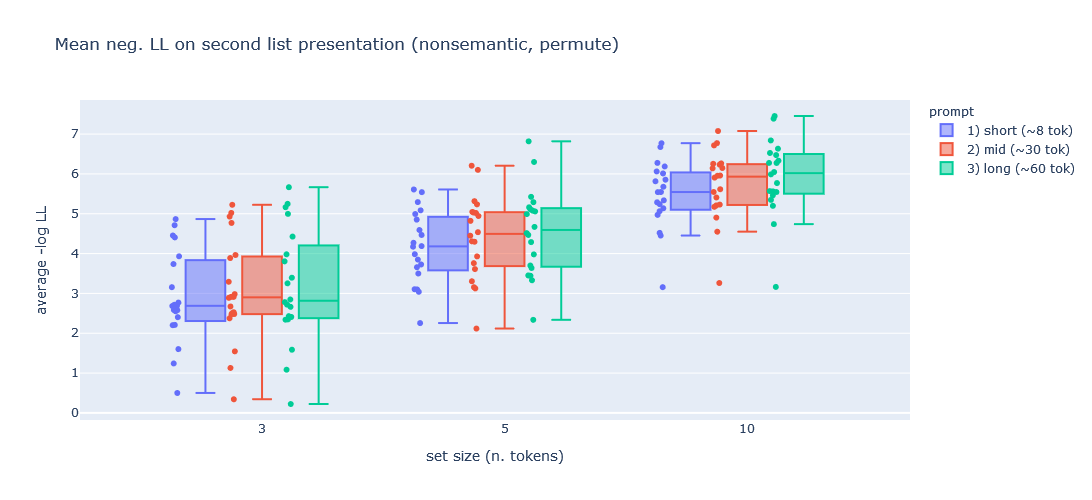

In [154]:
fig = px.box(dagg, x="set_size_", y="ppl_mean", points="all", color="prompt_", 
             hover_data=["token_list"], 
             labels={"set_size_": "set size (n. tokens)", "ppl_mean": "average -log LL",
                   "prompt_": "prompt", "second_list_": "word order", "ppl_diff": "loss diff (first-second)"},
            category_orders = {"prompt": ["short (~8 tok)", "mid (~30 tok)", "long (~60 tok)"]},
            width=figwidth, height=figheight,
            title="Mean neg. LL on second list presentation ({}, {})" \
                   .format(semlist, wordorder))
fig.update_xaxes(type='category')
fig.show()

In [12]:
fig.write_image("./figures/perp_{}_{}.png".format(semlist, wordorder))

In [13]:
# let's filter some stuff
dftmp = None
semlist = "nonsemantic"
wordorder = "repeat"
dftmp = df2.loc[(~df2.ispunct)  & (df2.list == semlist) & (df2.second_list == wordorder), :]          # remove punctuation
dftmp = dftmp.loc[(dftmp.trialID == 3), :]  # only look at the first presentation word list
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-1", "1) short (~8 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-3", "2) mid (~30 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-5", "3) long (~60 tok)")

dagg = None
dagg = dftmp.groupby(["prompt", "set_size", "stimID"]) \
            .agg({"ppl": ["mean", "std"], "token": list}) \
            .reset_index()
dagg.columns = ['_'.join(col).strip() for col in dagg.columns.values]

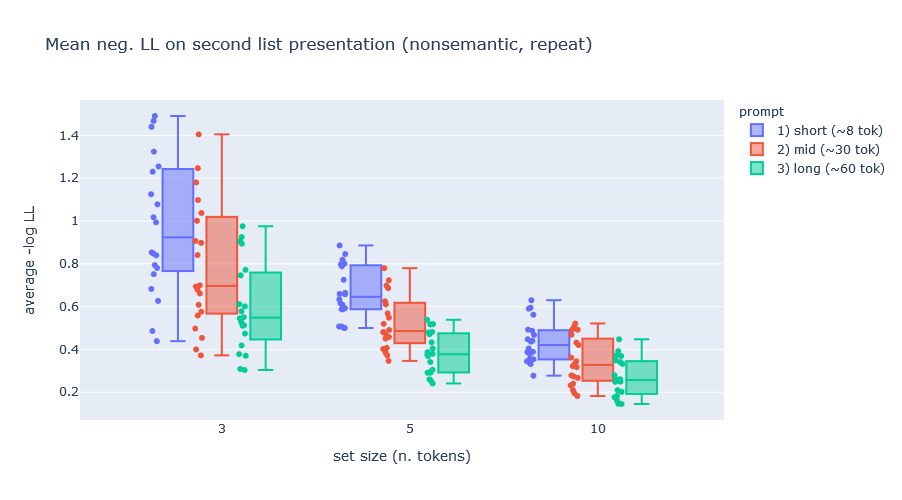

In [14]:
fig = px.box(dagg, x="set_size_", y="ppl_mean", points="all", color="prompt_", 
             hover_data=["token_list"], 
             labels={"set_size_": "set size (n. tokens)", "ppl_mean": "average -log LL",
                   "prompt_": "prompt", "second_list_": "word order"},
            category_orders = {"prompt": ["short (~8 tok)", "mid (~30 tok)", "long (~60 tok)"]},
            width=figwidth, height=figheight,
            title="Mean neg. LL on second list presentation ({}, {})" \
                   .format(semlist, wordorder))
fig.update_xaxes(type='category')
fig.show()

In [15]:
fig.write_image("./figures/perp_{}_{}.png".format(semlist, wordorder))

In [16]:
# let's filter some stuff
dftmp = None
semlist = "semantic"
wordorder = "repeat"
dftmp = df2.loc[(~df2.ispunct)  & (df2.list == semlist) & (df2.second_list == wordorder), :]          # remove punctuation
dftmp = dftmp.loc[(dftmp.trialID == 3), :]  # only look at the first presentation word list
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-1", "1) short (~8 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-3", "2) mid (~30 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-5", "3) long (~60 tok)")

In [17]:
dagg = None
dagg = dftmp.groupby(["prompt", "set_size", "stimID"]) \
            .agg({"ppl": ["mean", "std"], "token": list}) \
            .reset_index()
dagg.columns = ['_'.join(col).strip() for col in dagg.columns.values]

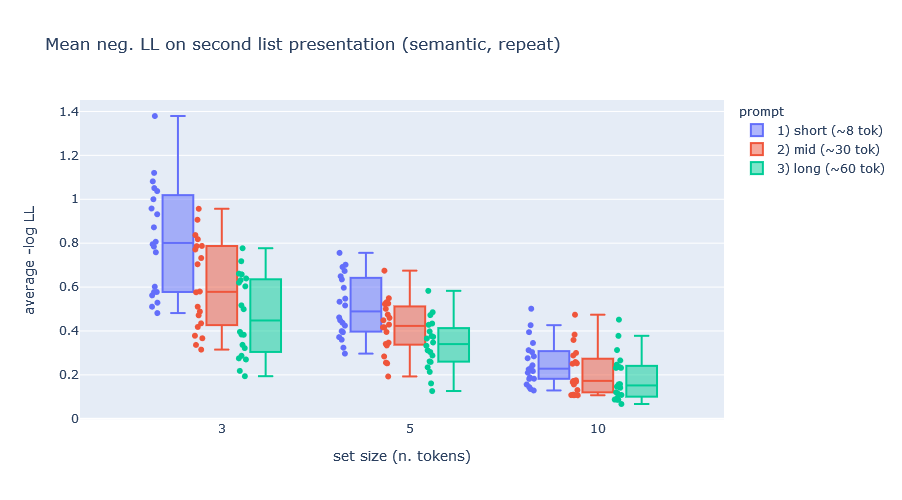

In [18]:
fig = px.box(dagg, x="set_size_", y="ppl_mean", points="all", color="prompt_", 
             hover_data=["token_list"], 
             labels={"set_size_": "set size (n. tokens)", "ppl_mean": "average -log LL",
                   "prompt_": "prompt", "second_list_": "word order"},
            category_orders = {"prompt": ["short (~8 tok)", "mid (~30 tok)", "long (~60 tok)"]},
            width=figwidth, height=figheight,
            title="Mean neg. LL on second list presentation ({}, {})" \
                   .format(semlist, wordorder))
fig.update_xaxes(type='category')
fig.show()

In [19]:
fig.write_image("./figures/perp_{}_{}.png".format(semlist, wordorder))

In [20]:
# let's filter some stuff
dftmp = None
semlist = "semantic"
wordorder = "permute"
dftmp = df2.loc[(~df2.ispunct)  & (df2.list == semlist) & (df2.second_list == wordorder), :]          # remove punctuation
dftmp = dftmp.loc[(dftmp.trialID == 3), :]  # only look at the first presentation word list
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-1", "1) short (~8 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-3", "2) mid (~30 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-5", "3) long (~60 tok)")

In [21]:
dagg = None
dagg = dftmp.groupby(["prompt", "set_size", "stimID"]) \
            .agg({"ppl": ["mean", "std"], "token": list}) \
            .reset_index()
dagg.columns = ['_'.join(col).strip() for col in dagg.columns.values]

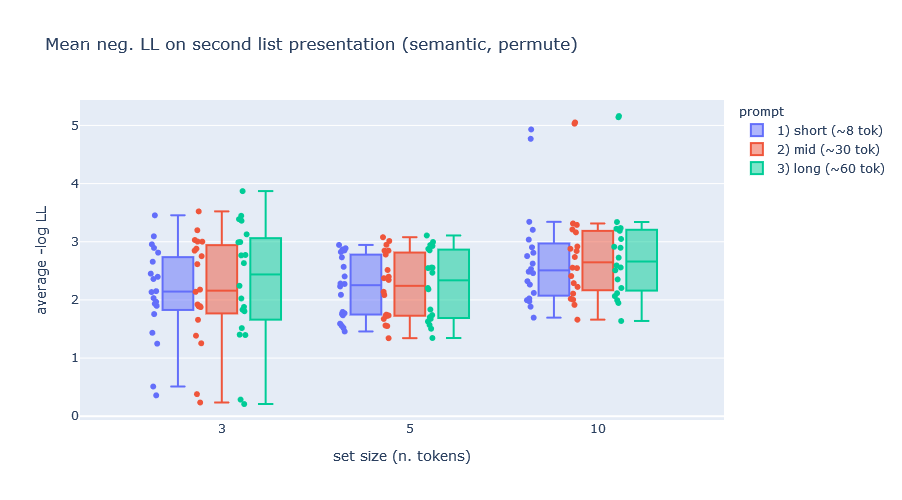

In [22]:
fig = px.box(dagg, x="set_size_", y="ppl_mean", points="all", color="prompt_", 
             hover_data=["token_list"], 
             labels={"set_size_": "set size (n. tokens)", "ppl_mean": "average -log LL",
                   "prompt_": "prompt", "second_list_": "word order"},
            category_orders = {"prompt": ["short (~8 tok)", "mid (~30 tok)", "long (~60 tok)"]},
            width=figwidth, height=figheight,
            title="Mean neg. LL on second list presentation ({}, {})" \
                   .format(semlist, wordorder))
fig.update_xaxes(type='category')
fig.show()

In [23]:
fig.write_image("./figures/perp_{}_{}.png".format(semlist, wordorder))

In [24]:
# let's filter some stuff
dftmp = None
semlist = "nonsemantic"
wordorder = "repeat"
dftmp = df2.loc[(~df2.ispunct)  & (df2.list == semlist) & (df2.second_list == wordorder), :]          # remove punctuation
dftmp = dftmp.loc[(dftmp.trialID == 1), :]  # only look at the cue presentation word list
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-1", "1) short (~8 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-3", "2) mid (~30 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-5", "3) long (~60 tok)")

In [25]:
dagg = None
dagg = dftmp.groupby(["prompt", "set_size", "stimID"]) \
            .agg({"ppl": ["mean", "std"], "token": list}) \
            .reset_index()
dagg.columns = ['_'.join(col).strip() for col in dagg.columns.values]

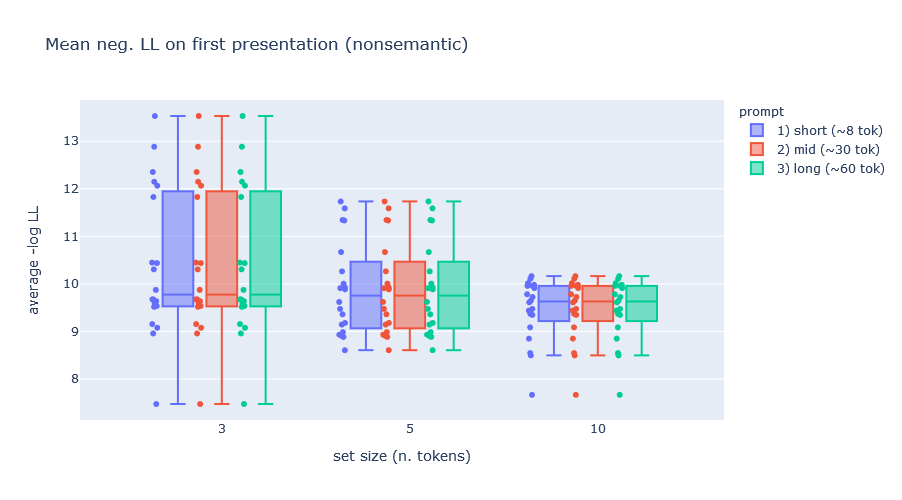

In [26]:
fig = px.box(dagg, x="set_size_", y="ppl_mean", points="all", color="prompt_", 
             hover_data=["token_list"], 
             labels={"set_size_": "set size (n. tokens)", "ppl_mean": "average -log LL",
                   "prompt_": "prompt", "second_list_": "word order"},
            category_orders = {"prompt": ["short (~8 tok)", "mid (~30 tok)", "long (~60 tok)"]},
            width=figwidth, height=figheight,
            title="Mean neg. LL on first presentation ({})" \
                   .format(semlist))
fig.update_xaxes(type='category')
fig.show()

In [27]:
fig.write_image("./figures/perp_{}_{}_cue.png".format(semlist, wordorder))

In [28]:
# let's filter some stuff
dftmp = None
semlist = "semantic"
wordorder = "repeat"
dftmp = df2.loc[(~df2.ispunct)  & (df2.list == semlist) & (df2.second_list == wordorder), :]          # remove punctuation
dftmp = dftmp.loc[(dftmp.trialID == 1), :]                                                            # only look at the cue presentation word list
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-1", "1) short (~8 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-3", "2) mid (~30 tok)")
dftmp["prompt"] = dftmp["prompt"].str.replace("sce1-5", "3) long (~60 tok)")

In [29]:
dagg = None
dagg = dftmp.groupby(["prompt", "set_size", "stimID"]) \
            .agg({"ppl": ["mean", "std"], "token": list}) \
            .reset_index()
dagg.columns = ['_'.join(col).strip() for col in dagg.columns.values]

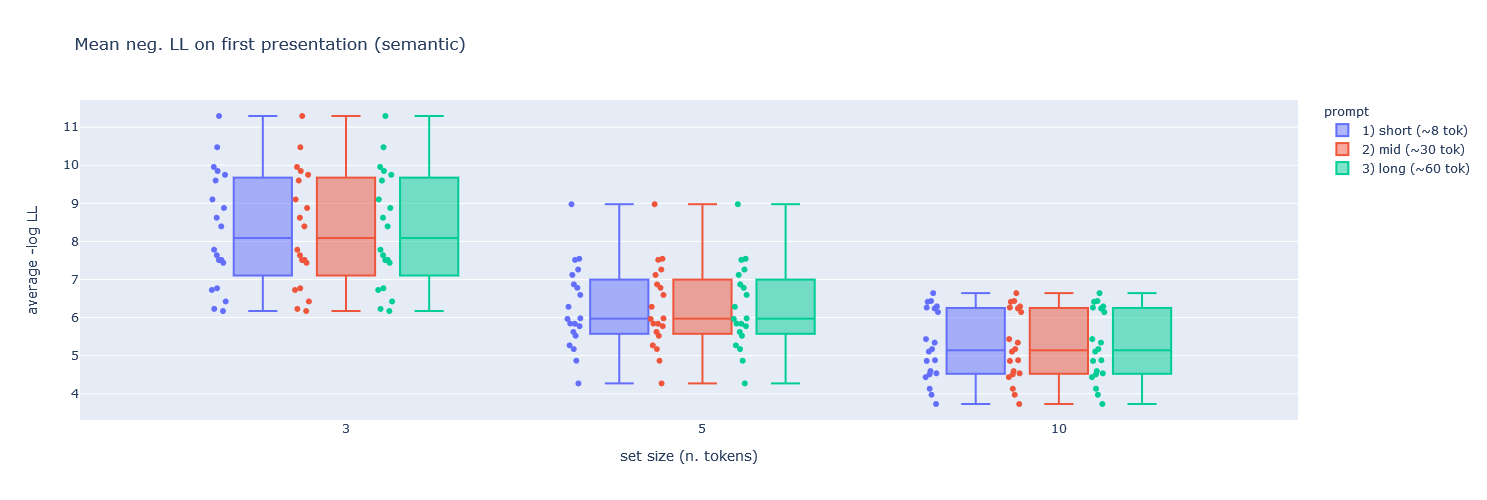

In [31]:
fig = px.box(dagg, x="set_size_", y="ppl_mean", points="all", color="prompt_", 
             hover_data=["token_list"], 
             labels={"set_size_": "set size (n. tokens)", "ppl_mean": "average -log LL",
                   "prompt_": "prompt", "second_list_": "word order"},
            category_orders = {"prompt": ["short (~8 tok)", "mid (~30 tok)", "long (~60 tok)"]},
            width=figwidth, height=figheight,
            title="Mean neg. LL on first presentation ({})" \
                   .format(semlist))
fig.update_xaxes(type='category')
fig.show()

In [32]:
fig.write_image("./figures/perp_{}_{}_cue.png".format(semlist, wordorder))